In [1]:
import pandas as pd
import glob
import warnings
import time
import matplotlib.pyplot as plt

from pandas import DataFrame

warnings.filterwarnings('ignore')


def loadFullDataframe():
    path = './'
    all_files = glob.glob(path + "SPY*2019*.csv")

    # List to hold DataFrames
    df_list = []

    for file in all_files:
        # Read the CSV file
        print("Sto caricando il file: " + file + " dentro il df generale.")
        df = pd.read_csv(file)

        # Select columns
        selected_columns = ['optionalias', 'underlying_last', 'strike', 'type', 'expiration', 'quotedate',
                            'openinterest','volume','ask','bid']
        df_selected = df[selected_columns]

        # Filter where openinterest > 0
        df_filtered = df_selected[df_selected['openinterest'] > 0]

        # Convert and format date columns
        df_filtered['expiration'] = pd.to_datetime(df_filtered['expiration'], format='%m/%d/%Y').dt.strftime('%d/%m/%Y')
        df_filtered['quotedate'] = pd.to_datetime(df_filtered['quotedate'], format='%m/%d/%Y').dt.strftime('%d/%m/%Y')

        df_filtered['expiration'] = pd.to_datetime(df_filtered['expiration'], format='%d/%m/%Y')
        df_filtered['quotedate'] = pd.to_datetime(df_filtered['quotedate'], format='%d/%m/%Y')

        # Append to the list
        df_list.append(df_filtered)

    # Concatenate all DataFrames in the list
    return pd.concat(df_list, ignore_index=True)


def findingEntryPriceToFurthestExpiration(df):
    df_max_expiration = df[df['expiration'] == df['expiration'].max()]
    df_max_expiration['strike_diff'] = abs(df_max_expiration['strike'] - df_max_expiration['underlying_last'])
    nearest_strike_row = df_max_expiration.loc[df_max_expiration['strike_diff'].idxmin()]
    return nearest_strike_row


def findingOptionCodeByAlias(df, alias):
    result = df[df['optionalias'] == alias]
    if not result.empty:
        return result.iloc[0]
    else:
        return pd.Series()


def calculateBuyOptionsProfit(dfDayBeforeTheExpiration, dfdayAfterExiration, capitalBuyCallOptions,
                              howFarToOpenOptions):
    # TODO DA PARAMETRIZZARE L'EXPIRATION PER QUANDO APRIRE
    entry_row = findingEntryPriceToFurthestExpiration(dfDayBeforeTheExpiration)
    entry_cost = entry_row.ask * 100

    exit_row = findingOptionCodeByAlias(dfdayAfterExiration, entry_row.optionalias)
    exit_credit = exit_row.bid * 100

    positions = capitalBuyCallOptions // entry_cost
    remaining_capital = capitalBuyCallOptions - positions * entry_cost
    return exit_credit * positions + remaining_capital


def calculateBuyStockProfit(underlyingBeforeTheExpiration, underlyingAfterTheExpiration, capitalBuyStock):
    positions = capitalBuyStock // underlyingBeforeTheExpiration
    remaining_capital = capitalBuyStock - positions * underlyingBeforeTheExpiration

    return underlyingAfterTheExpiration * positions + remaining_capital  # fees


def calculateSellPutProfit(dfDayBeforeTheExpiration, dfdayAfterExiration, capitalSellPutOptions, howFarToOpenOptions):
    # TODO DA PARAMETRIZZARE L'EXPIRATION PER QUANDO APRIRE
    entry_row = findingEntryPriceToFurthestExpiration(dfDayBeforeTheExpiration)
    entry_credit = entry_row.bid * 100

    exit_row = findingOptionCodeByAlias(dfdayAfterExiration, entry_row.optionalias)
    exit_cost = exit_row.ask * 100

    positions = capitalSellPutOptions // entry_credit
    return capitalSellPutOptions + (entry_credit - exit_cost) * positions


class LaunchParams:
    capitalBuyCallOptions = None
    capitalBuyStock = None
    capitalSellPutOptions = None
    daysAfter = None
    daysBefore = None
    percStrikeDaysBefore = None

def getPercentAboveOI(dfBeforeTheExpirationFilteredByExpiration, percStrikeDaysBefore):
    underlingBeforeExpiration = dfBeforeTheExpirationFilteredByExpiration['underlying_last'].iloc[0]
    strikeAtOpen = underlingBeforeExpiration * percStrikeDaysBefore / 100 + underlingBeforeExpiration
    oi_below_threshold = \
        dfBeforeTheExpirationFilteredByExpiration[strikeAtOpen > dfBeforeTheExpirationFilteredByExpiration['strike']][
            'openinterest'].sum()
    oi_above_threshold = \
        dfBeforeTheExpirationFilteredByExpiration[strikeAtOpen <= dfBeforeTheExpirationFilteredByExpiration['strike']][
            'openinterest'].sum()
    total_open_interest = dfBeforeTheExpirationFilteredByExpiration['openinterest'].sum()
    percent_oi_below = (oi_below_threshold / total_open_interest) * 100 if total_open_interest > 0 else 0
    percent_oi_above = (oi_above_threshold / total_open_interest) * 100 if total_open_interest > 0 else 0
    return percent_oi_below, percent_oi_above

def getPercentAboveVolume(dfBeforeTheExpirationFilteredByExpiration, percStrikeDaysBefore):
    underlingBeforeExpiration = dfBeforeTheExpirationFilteredByExpiration['underlying_last'].iloc[0]
    strikeAtOpen = underlingBeforeExpiration * percStrikeDaysBefore / 100 + underlingBeforeExpiration
    volume_below_threshold = \
        dfBeforeTheExpirationFilteredByExpiration[strikeAtOpen > dfBeforeTheExpirationFilteredByExpiration['strike']][
            'volume'].sum()
    volume_above_threshold = \
        dfBeforeTheExpirationFilteredByExpiration[strikeAtOpen <= dfBeforeTheExpirationFilteredByExpiration['strike']][
            'volume'].sum()
    total_open_volume = dfBeforeTheExpirationFilteredByExpiration['volume'].sum()
    percent_vol_below = (volume_below_threshold / total_open_volume) * 100 if total_open_volume > 0 else 0
    percent_vol_above = (volume_above_threshold / total_open_volume) * 100 if total_open_volume > 0 else 0
    return percent_vol_below, percent_vol_above
    
def getDFDayAfterExpiration(DFFull, nextExpirationDate, daysAfter):
    dayAfterTheExpiration = nextExpirationDate + pd.Timedelta(days=daysAfter)
    df_after_expiration = DFFull[DFFull['quotedate'] >= dayAfterTheExpiration.strftime('%Y-%m-%d')]
    closest_row_after_expiration = df_after_expiration.iloc[
        (df_after_expiration['quotedate'] - dayAfterTheExpiration).abs().argsort()[:1]]
    return closest_row_after_expiration
    





In [2]:
DFFull = loadFullDataframe()


Sto caricando il file: .\SPY_20190102_to_20190131.csv dentro il df generale.
Sto caricando il file: .\SPY_20190201_to_20190228.csv dentro il df generale.
Sto caricando il file: .\SPY_20190301_to_20190329.csv dentro il df generale.
Sto caricando il file: .\SPY_20190401_to_20190430.csv dentro il df generale.
Sto caricando il file: .\SPY_20190501_to_20190531.csv dentro il df generale.
Sto caricando il file: .\SPY_20190603_to_20190628.csv dentro il df generale.
Sto caricando il file: .\SPY_20190701_to_20190731.csv dentro il df generale.
Sto caricando il file: .\SPY_20190801_to_20190830.csv dentro il df generale.
Sto caricando il file: .\SPY_20190903_to_20190930.csv dentro il df generale.
Sto caricando il file: .\SPY_20191001_to_20191031.csv dentro il df generale.
Sto caricando il file: .\SPY_20191101_to_20191129.csv dentro il df generale.
Sto caricando il file: .\SPY_20191202_to_20191231.csv dentro il df generale.


In [3]:
def calculateProfit(DFFull: DataFrame, params: LaunchParams):
    start_time = time.time()
    resultDF = pd.DataFrame(columns=['date', 'capital','underlingBefore','underlingAfter',
                                     'percent_oi_winning_call', 'percent_oi_losing_call',
                                     'percent_oi_winning_put','percent_oi_losing_put',
                                     'percent_vol_winning_call','percent_vol_losing_call',
                                     'percent_vol_winning_put','percent_vol_losing_put'
                                    ])

    for nextExpirationDate in sorted(DFFull['expiration'].unique().tolist()):
        #print("nextExpirationDate " + nextExpirationDate.strftime("%Y-%m-%d"))
        dateBeforeTheExpiration = nextExpirationDate - pd.Timedelta(days=params.daysBefore)

        dfBeforeTheExpirationFull = DFFull[DFFull['quotedate'] == dateBeforeTheExpiration.strftime('%Y-%m-%d')]
        dfBeforeTheExpirationFullCall = dfBeforeTheExpirationFull[dfBeforeTheExpirationFull['type'] == "call"]
        dfBeforeTheExpirationFullPut = dfBeforeTheExpirationFull[dfBeforeTheExpirationFull['type'] == "put"]

        dfBeforeTheExpirationFilteredByExpiration = dfBeforeTheExpirationFull[
            dfBeforeTheExpirationFull['expiration'] == nextExpirationDate.strftime('%Y-%m-%d')]
        dfBeforeTheExpirationFilteredByExpirationCall = dfBeforeTheExpirationFilteredByExpiration[
            dfBeforeTheExpirationFull['type'] == "call"]
        dfBeforeTheExpirationFilteredByExpirationPut = dfBeforeTheExpirationFull[
            dfBeforeTheExpirationFull['type'] == "put"]

        if (len(dfBeforeTheExpirationFilteredByExpirationCall) == 0 or len(
                dfBeforeTheExpirationFilteredByExpirationPut) == 0):
            #print("dfdayBeforeTheExpirationFilteredByExp empty")
            continue

        underlyingBeforeTheExpiration = dfBeforeTheExpirationFilteredByExpirationCall.iloc[0].underlying_last

        dfAfterTheExpirationFilteredByExpiration = getDFDayAfterExpiration(DFFull, nextExpirationDate, params.daysAfter)
        if (len(dfAfterTheExpirationFilteredByExpiration) == 0):
            #print("dfAfterTheExpirationFilteredByExpiration empty")
            continue
        underlyingAfterTheExpiration = dfAfterTheExpirationFilteredByExpiration['underlying_last'].iloc[0]

        dfAfterTheExpiration = DFFull[
            DFFull['quotedate'] == dfAfterTheExpirationFilteredByExpiration['quotedate'].iloc[0].strftime('%Y-%m-%d')]

        dfAfterTheExpirationFilteredByExpirationCall = dfAfterTheExpiration[dfAfterTheExpiration['type'] == "call"]
        dfAfterTheExpirationFilteredByExpirationPut = dfAfterTheExpiration[dfAfterTheExpiration['type'] == "put"]

        percent_oi_winning_call, percent_oi_losing_call = getPercentAboveOI(dfBeforeTheExpirationFilteredByExpirationCall,
                                                                  launchParams.percStrikeDaysBefore)
        
        percent_oi_winning_put, percent_oi_losing_put = getPercentAboveOI(dfBeforeTheExpirationFilteredByExpirationPut,
                                                                  launchParams.percStrikeDaysBefore)

        percent_vol_winning_call, percent_vol_losing_call = getPercentAboveVolume(dfBeforeTheExpirationFilteredByExpirationCall,
                                                                  launchParams.percStrikeDaysBefore)

        percent_vol_winning_put, percent_vol_losing_put = getPercentAboveVolume(dfBeforeTheExpirationFilteredByExpirationPut,
                                                                  launchParams.percStrikeDaysBefore)

        if percent_oi_winning_call < 5:
            params.capitalBuyStock = calculateBuyStockProfit(underlyingBeforeTheExpiration,
                                                                 underlyingAfterTheExpiration,
                                                                 params.capitalBuyStock)

        #capitalBuyCallOptions = calculateBuyOptionsProfit(dfBeforeTheExpirationFullCall,
        #                                                  dfAfterTheExpirationFilteredByExpirationCall,
        #                                                  params.capitalBuyCallOptions,
        #                                                  launchParams.howFarToOpenOptions)
#
        #capitalSellPutOptions = calculateSellPutProfit(dfBeforeTheExpirationFullPut,
        #                                               dfAfterTheExpirationFilteredByExpirationPut,
        #                                               params.capitalSellPutOptions, launchParams.howFarToOpenOptions)

        # Create a new row as a dictionary and append it to the DataFrame
        resultDF.loc[len(resultDF)] = [nextExpirationDate, params.capitalBuyStock,underlyingBeforeTheExpiration,underlyingAfterTheExpiration,
                                       percent_oi_winning_call, percent_oi_losing_call,
                                       percent_oi_winning_put,percent_oi_losing_put,
                                       percent_vol_winning_call, percent_vol_losing_call,
                                       percent_vol_winning_put, percent_vol_losing_put
                                      ]
        
    end_time = time.time()
    print(f"Time taken: {end_time - start_time} seconds")
    return resultDF

Time taken: 10.514698505401611 seconds


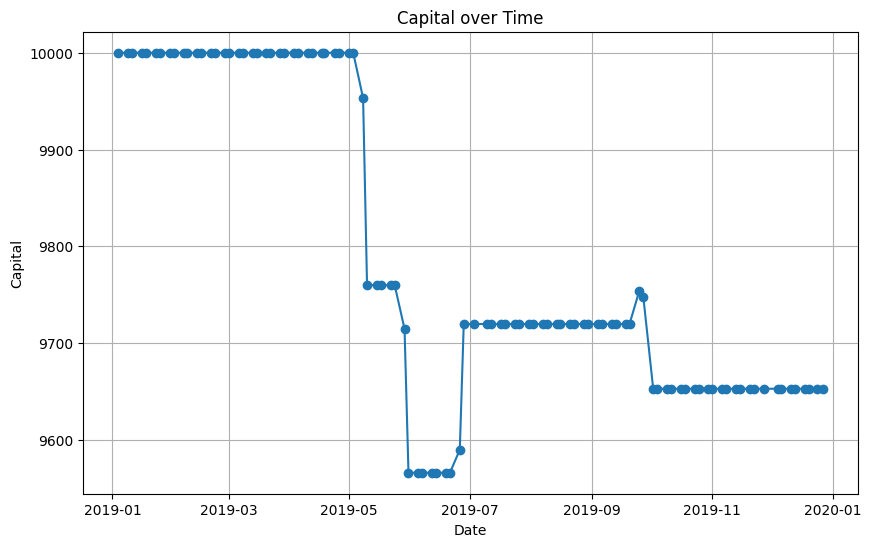

In [4]:
launchParams = LaunchParams()
launchParams.capitalBuyCallOptions = 10000
launchParams.capitalSellPutOptions = 10000
launchParams.capitalBuyStock = 10000
launchParams.daysAfter = 1
launchParams.daysBefore = 1
launchParams.percStrikeDaysBefore = 0
launchParams.howFarToOpenOptions = 10


resultDataframe = calculateProfit(DFFull, launchParams)


plt.figure(figsize=(10, 6))
plt.plot(resultDataframe['date'], resultDataframe['capital'], marker='o', linestyle='-')
plt.title('Capital over Time')
plt.xlabel('Date')
plt.ylabel('Capital')
plt.grid(True)
plt.show()


In [7]:
resultDataframe.to_csv("ciao.csv")